
### 1. Análisis y pronóstico de series de tiempo

- Seleccionar una base de datos con al menos una serie de tiempo univariada (se sugiere además considerar variables adicionales para generar un enfoque multivariado que se usará posteriormente).
- Aplicar un modelo de pronóstico **lineal clásico** (por ejemplo, SARIMAX) **solo para el caso univariado**. Recuerda usar y argumentar todo el análisis que debe ser realizado para este tipo de modelos.
- Evaluar el desempeño del modelo lineal como línea base (Usar métricas como MAPE, MSE y $R^2$).

In [1]:
import pandas as pd
import seaborn as snsimport
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, MaxPooling1D
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import optuna
from tensorflow.keras.regularizers import l2
#from mlflow_runs import MLflowCallback
#mlflow_callback = MLflowCallback()

/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("Data/air_quality_clean.csv")
df

,Datetime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04 10:00:00,3.1,1314.0,13.5,1101.0,539.0,1374.0,1729.0,21.9,29.3,0.7568
9353,2005-04-04 11:00:00,2.4,1163.0,11.4,1027.0,604.0,1264.0,1269.0,24.3,23.7,0.7119
9354,2005-04-04 12:00:00,2.4,1142.0,12.4,1063.0,603.0,1241.0,1092.0,26.9,18.3,0.6406
9355,2005-04-04 13:00:00,2.1,1003.0,9.5,961.0,702.0,1041.0,770.0,28.3,13.5,0.5139


## Modelo lineal básico

In [4]:
# Seleccionar la serie univariada
series = df['CO(GT)']

In [5]:
# Separar train y test
train_size = int(len(series) * 0.8) # 80% para train
train, test = series[:train_size], series[train_size:]

In [6]:
# Ajustar modelo SARIMAX base
model = SARIMAX(train, order=(1,0,1), seasonal_order=(1,0,1,24), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

In [7]:
# Pronosticar
forecast = model_fit.forecast(steps=len(test))

In [8]:
    # Evaluación
mape = mean_absolute_percentage_error(test, forecast)
mse = mean_squared_error(test, forecast)
r2 = r2_score(test, forecast)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.741
MSE: 1.431
R²: 0.222


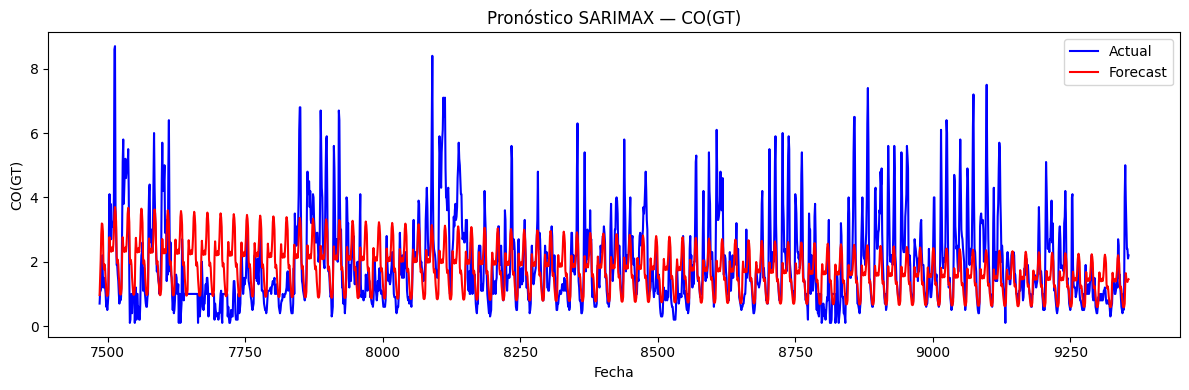

In [9]:
plt.figure(figsize=(12,4))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('Pronóstico SARIMAX — CO(GT)')
plt.xlabel('Fecha')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Rango de parámetros
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 24  # estacionalidad diaria (horaria)

# Guardar resultados
mejores_resultados = []
mejor_r2 = -np.inf
mejores_parametros = None

# Grid Search
for order in [(i, j, k) for i in p for j in d for k in q]:
    for seasonal_order in [(i, j, k, s) for i in P for j in D for k in Q]:
        try:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            fit = model.fit(disp=False)
            forecast = fit.forecast(steps=len(test))
            r2 = r2_score(test, forecast)
            mape = mean_absolute_percentage_error(test, forecast)
            mse = mean_squared_error(test, forecast)
            mejores_resultados.append((order, seasonal_order, r2, mape, mse))
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejores_parametros = (order, seasonal_order)
        except:
            continue

# Mostrar mejores parámetros
print("Mejor modelo:")
print("Order:", mejores_parametros[0])
print("Seasonal Order:", mejores_parametros[1])
print(f"R²: {mejor_r2:.3f}")


A pesar de usar el gridsearch para encontrar mejores valores para p,d y q, el resultado no mejoró significativamente. Subio de 0.22 a 0.25. Se puede observar que la predicción no se ajusta bien a los datos reales. 

### 2. Modelos neuronales para series de tiempo

- Desarrollar e implementar los siguientes modelos para el pronóstico de la serie:
  - **Multilayer Perceptron (MLP)**
  - **Convolutional Neural Network (CNN)**
  - **Long Short-Term Memory (LSTM)**
  - **Conv-LSTM**

- Implementar cada uno de los modelos anteriores **tanto para el caso univariado como multivariado**.
- Comparar el desempeño de los modelos neuronales **univariados vs. multivariados**.
- Comparar el desempeño de los modelos neuronales **univariados** con el modelo **lineal clásico**. Crear gráficas donde se evidencie la predicción en el conjunto de test tanto del modelo lineal como no lineal

> Seleccionar al menos 3 estructuras de cada modelo. De todo el conjunto de modelos entrenados, seleccionar el modelo que obtuvo mejor rendimiento. A dicho modelo hacer una optimización parámetrica usando optuna. Recuerde que si usa callbacks como `EarlyStopping`, debe configurarse apropiadamente para permitir que el modelo se entrene una cantidad de épocas apropiadas.


# MLP


In [10]:
# Preparar la serie
serie = df['CO(GT)'].dropna().values.reshape(-1, 1)

In [11]:
# Escalar los datos
scaler = MinMaxScaler()
serie_scaled = scaler.fit_transform(serie)

In [12]:
# ventanas deslizantes
def crear_ventanas(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 24  # 24 horas
X, y = crear_ventanas(serie_scaled, window_size)

In [13]:
# Dividir en train test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [15]:
# Callback de EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',   # monitorea la pérdida de validación
    patience=5,           # espera 5 épocas sin mejora
    restore_best_weights=True  # restaura los pesos de la mejor época
)

# MLP
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(window_size,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar con validación y early stopping
model.fit(
    X_train, y_train,
    validation_split=0.2,       
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0076 - val_loss: 0.0048
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - val_loss: 0.0048
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - val_loss: 0.0048
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025 - val_loss: 0.0043
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0049
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0050
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - val_loss: 0.0045


In [16]:
# Predicciones 
y_pred = model.predict(X_test)

# Invertir escala 
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

#Evaluación
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE: 0.409
MSE: 0.375
R²: 0.796


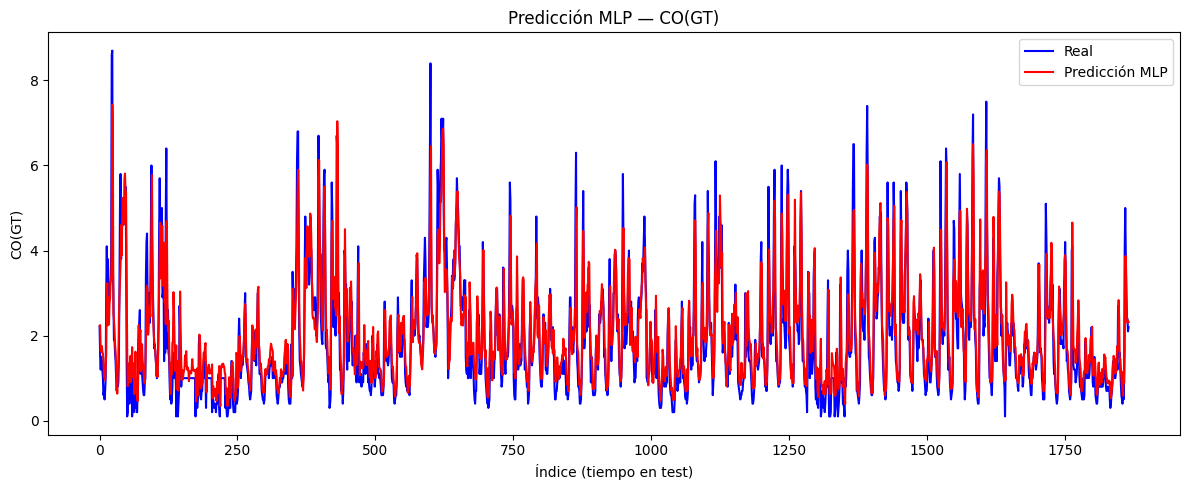

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(y_pred_inv, label='Predicción MLP', color='red')
plt.title('Predicción MLP — CO(GT)')
plt.xlabel('Índice (tiempo en test)')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


## Resultados 
- MAPE (Mean Absolute Percentage Error): 0.409

Esto significa que, en promedio, el modelo se equivoca un 40.9% respecto al valor real.

Es una métrica útil para entender el error en términos relativos, pero puede ser sensible cuando los valores reales son muy pequeños.

- MSE (Mean Squared Error): 0.375

Es el promedio del cuadrado de los errores (diferencias entre las predicciones y los valores reales).

Penaliza más los errores grandes.

Cuanto más bajo, mejor.

- R² (Coeficiente de determinación): 0.796

Representa cuánta varianza de los datos está siendo explicada por el modelo.

Un valor de 0.796 indica que el modelo explica aproximadamente el 79.6% de la varianza de los datos. Bastante bien, pero hay espacio para mejorar.

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',   # monitorea la pérdida de validación
    patience=5,           # espera 5 épocas sin mejora
    restore_best_weights=True  # restaura los pesos de la mejor época
)

# MLP
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(window_size,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar con validación y early stopping
model.fit(
    X_train, y_train,
    validation_split=0.2,       
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0049
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023 - val_loss: 0.0047
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0049


In [20]:
# Predicciones 
y_pred = model.predict(X_test)

# Invertir escala 
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

#Evaluación
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE: 0.332
MSE: 0.351
R²: 0.809


El segundo MLP es mejor en todo:

Tiene un MAPE 7.7% menor, lo que indica que sus errores relativos son más pequeños.

El MSE también baja, lo que significa que los errores en general son más pequeños.

El R² sube a 0.809, indicando que el modelo explica un mayor porcentaje de la varianza.

Menos capas → menos riesgo de sobreajuste.

Menos parámetros → más generalización.

Posiblemente el modelo anterior con tres capas (128-64-32) era innecesariamente complejo para los datos que tienes.

In [27]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# MLP profundo con regularización
model_deep = Sequential()
model_deep.add(Dense(256, activation='relu', input_shape=(window_size,), kernel_regularizer=l2(0.001)))
model_deep.add(BatchNormalization())
model_deep.add(Dropout(0.2))
model_deep.add(Dense(128, activation='relu'))
model_deep.add(BatchNormalization())
model_deep.add(Dropout(0.2))
model_deep.add(Dense(64, activation='relu'))
model_deep.add(Dense(1))

model_deep.compile(optimizer='adam', loss='mse')

# Entrenamiento
model_deep.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5435 - val_loss: 0.1757
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1363 - val_loss: 0.0747
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0898 - val_loss: 0.0712
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0704 - val_loss: 0.0568
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0594 - val_loss: 0.0524
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0527 - val_loss: 0.0486
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0475 - val_loss: 0.0488
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0436 - val_loss: 0.0393
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0396 - val_loss: 0.0408
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0364 - val_loss: 0.0351
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0334 - val_loss: 0.0322
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

In [29]:
# Predicciones 
y_pred = model_deep.predict(X_test)

# Invertir escala 
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

#Evaluación
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE: 0.417
MSE: 0.499
R²: 0.729


Comparado con el segundo modelo sencillo (128-64-1), el modelo profundo:

Tuvo peor MAPE (+8.5% más).

Tuvo peor MSE (+0.148 más).

Explicó menos varianza (R² bajó de 0.809 a 0.729).

# CNN

In [31]:
# Redimensionar para CNN 
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train Test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [33]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Modelo CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenamiento con validación y early stopping
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0087 - val_loss: 0.0050
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 0.0051
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026 - val_loss: 0.0041
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0051
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0042
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0044
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0048
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 0.0044
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [34]:
#Predicción
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Evaluación
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAPE: 0.362
MSE: 0.354
R²: 0.807


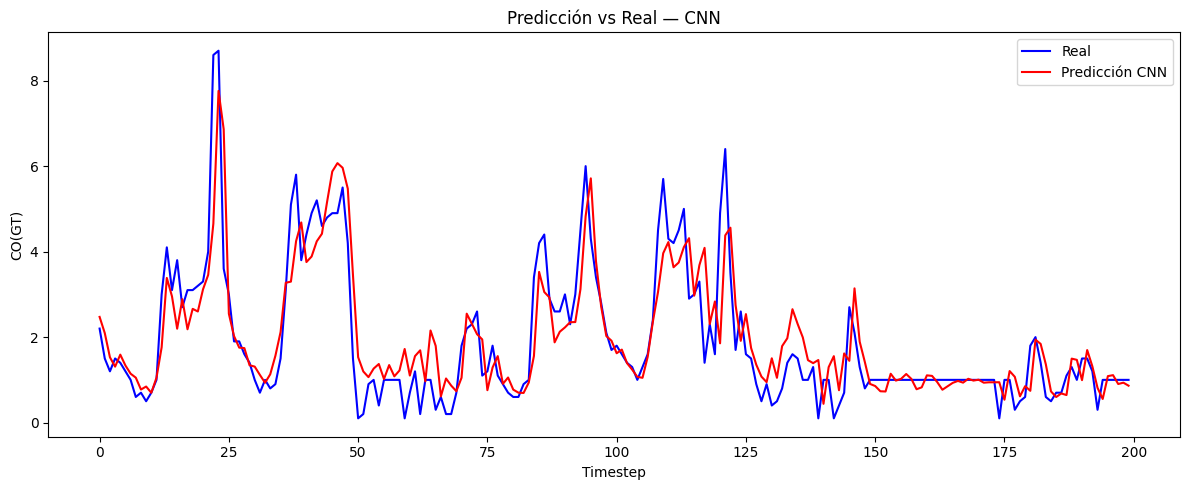

In [35]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción CNN', color='red')
plt.title('Predicción vs Real — CNN')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()

El rendimiento es muy similar al mejor MLP que probaste (128 → 64 → 1):

R²: 0.809 vs 0.807

MSE: 0.351 vs 0.354

MAPE: 0.332 vs 0.362

Esto sugiere que la CNN capta bien patrones locales (como picos o transiciones suaves en la serie), pero no necesariamente mejora el MLP en este caso.

In [41]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Modelo CNN más profundo
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.3))  # regularización
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1))  # salida

model_cnn.compile(optimizer='adam', loss='mse')

# Entrenamiento
model_cnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0084 - val_loss: 0.0100
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0038 - val_loss: 0.0054
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0030 - val_loss: 0.0075
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0033 - val_loss: 0.0062
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029 - val_loss: 0.0056
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0028 - val_loss: 0.0052
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - val_loss: 0.0052
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [43]:
#Predicción
y_pred = model_cnn.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Evaluación
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE: 0.392
MSE: 0.398
R²: 0.784


Aunque el modelo tenía más filtros y Dropout para controlar overfitting:

El MAPE y el MSE empeoraron respecto a la CNN más simple y al mejor MLP.

R² bajó respecto a ambos.

In [47]:

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Arquitectura CNN sin Activation() explícitas
model_cnn_1 = Sequential()
model_cnn_1.add(Conv1D(64, kernel_size=3, padding='same', activation='relu', input_shape=(window_size, 1)))
model_cnn_1.add(BatchNormalization())

model_cnn_1.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model_cnn_1.add(BatchNormalization())

model_cnn_1.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))

model_cnn_1.add(Flatten())
model_cnn_1.add(Dense(64, activation='relu'))
model_cnn_1.add(Dense(1))  # Sin activación aquí porque es regresión

model_cnn_1.compile(optimizer='adam', loss='mse')

# Entrenamiento
model_cnn_1.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1466 - val_loss: 0.0443
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0059 - val_loss: 0.0306
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0039 - val_loss: 0.0141
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0031 - val_loss: 0.0079
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024 - val_loss: 0.0056
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026 - val_loss: 0.0055
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0024 - val_loss: 0.0055
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0020 - val_loss: 0.0055
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021 - val_loss: 0.0053
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021 - val_loss: 0.0054
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

In [48]:
#Predicción
y_pred = model_cnn_1.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Evaluación
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAPE: 0.396
MSE: 0.459
R²: 0.751


Este modelo no mejoró los resultados previos.

De hecho, empeoró ligeramente respecto a la CNN mejorada anterior.


# LSTM

In [49]:
# Redimensionar para LSTM 
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [50]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Modelo LSTM
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(window_size, 1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar con validación y early stopping
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038 - val_loss: 0.0049
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0028 - val_loss: 0.0051
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0

In [22]:
# Predecir
y_pred = model.predict(X_test)

# Invertir escala
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Calcular métricas
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

# Mostrar resultados
print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE: 0.362
MSE: 0.383
R²: 0.792


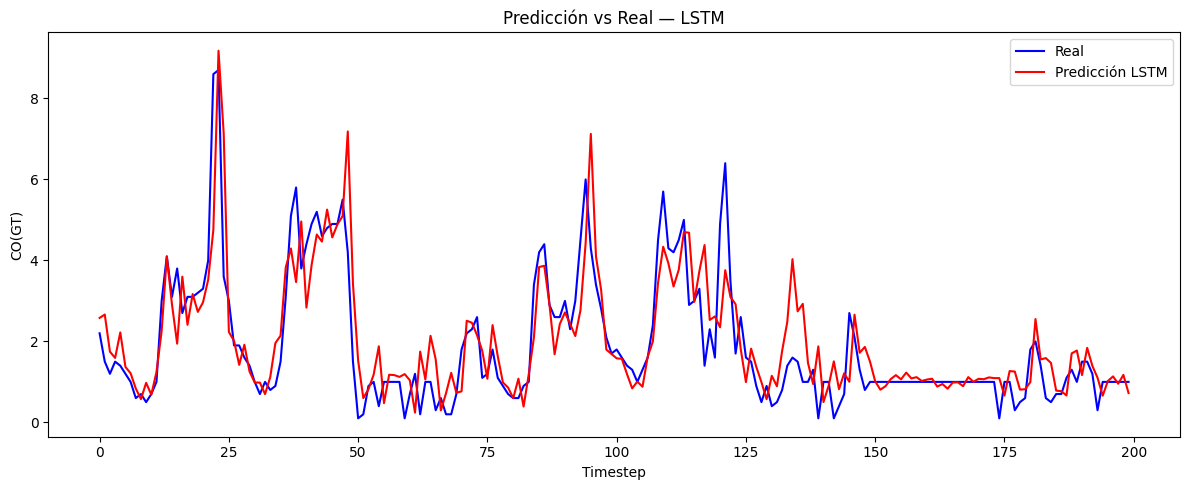

In [51]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción LSTM', color='red')
plt.title('Predicción vs Real — LSTM')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


El LSTM sí entendió las dependencias temporales, lo cual es positivo, pero:

No logró superar el MLP más simple (128–64–1) ni la CNN básica.

Tu mejor opción hasta ahora sigue siendo el MLP simple (128–64–1). Es:

El que menos error tiene (MAPE y MSE).

El que mejor generaliza (mayor R²).

Más eficiente que LSTM o CNN.

In [52]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Modelo LSTM profundo
model_lstm_deep = Sequential()
model_lstm_deep.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(window_size, 1)))
model_lstm_deep.add(Dropout(0.2))
model_lstm_deep.add(LSTM(32, activation='tanh'))
model_lstm_deep.add(Dropout(0.2))
model_lstm_deep.add(Dense(32, activation='relu'))
model_lstm_deep.add(Dense(1))

model_lstm_deep.compile(optimizer='adam', loss='mse')

# Entrenamiento
model_lstm_deep.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0125 - val_loss: 0.0132
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0073 - val_loss: 0.0117
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0039 - val_loss: 0.0056
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0033 - val_loss: 0.0048
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 

In [53]:
# Predecir
y_pred = model_lstm_deep.predict(X_test)

# Invertir escala
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Calcular métricas
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

# Mostrar resultados
print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MAPE: 0.327
MSE: 0.400
R²: 0.783


Aunque el MSE es ligeramente más alto que en el mejor MLP, el MAPE (error relativo) es el más bajo hasta ahora.

Esto indica que el modelo se adapta mejor a las proporciones del valor real, aunque a veces comete errores más grandes en términos absolutos.

R² más bajo significa que en términos de varianza explicada, no es el más completo

El LSTM profundo es el mejor modelo si te importa más el MAPE (error relativo).

El MLP simple sigue siendo el mejor si priorizas R² y MSE 

In [54]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Arquitectura LSTM básica
model_lstm_basic = Sequential()
model_lstm_basic.add(LSTM(32, activation='tanh', input_shape=(window_size, 1)))
model_lstm_basic.add(Dense(1))  # Salida directa

model_lstm_basic.compile(optimizer='adam', loss='mse')

# Entrenamiento
model_lstm_basic.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0146 - val_loss: 0.0139
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0073 - val_loss: 0.0081
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0053 - val_loss: 0.0064
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0038 - val_loss: 0.0049
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039 - val_loss: 0.0057
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - val_loss: 0.0046
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - val_loss: 0.0050
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034 - val_loss: 0.0045
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034 - val_loss: 0.0051
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.

In [55]:
# Predecir
y_pred = model_lstm_basic.predict(X_test)

# Invertir escala
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Calcular métricas
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

# Mostrar resultados
print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAPE: 0.402
MSE: 0.469
R²: 0.745


El LSTM básico es el que peor ha funcionado entre los modelos

Al no tener suficientes unidades ni profundidad, no logra capturar bien la dinámica temporal de tus datos.

# CONV-LSTM

In [57]:
# Modelo Conv-LSTM
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0097 - val_loss: 0.0055
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0037 - val_loss: 0.0060
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0032 - val_loss: 0.0052
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0030 - val_loss: 0.0050
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0028 - val_loss: 0.0049
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/st

In [58]:
# Predicción 
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Métricas 
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAPE: 0.361
MSE: 0.390
R²: 0.788


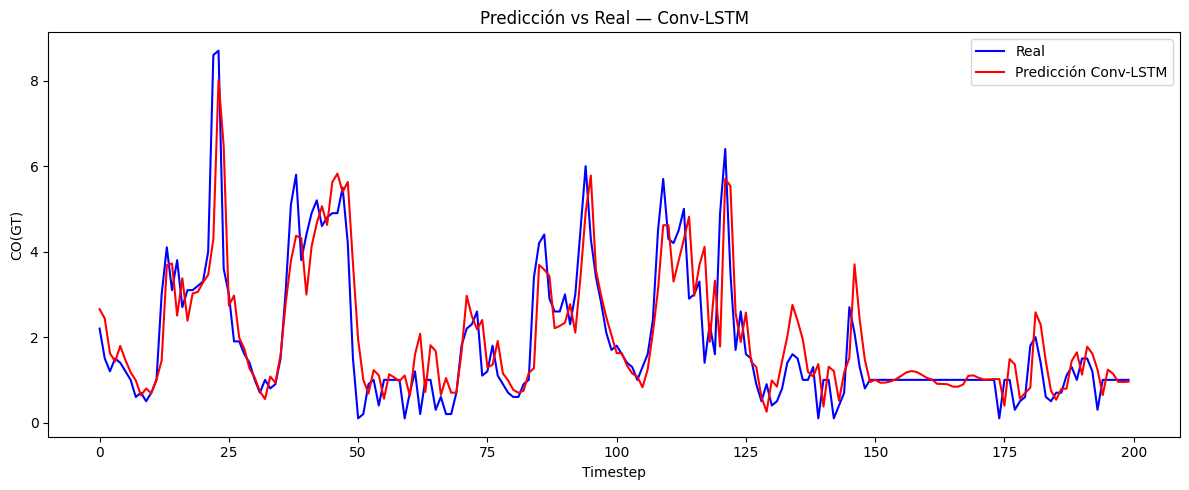

In [59]:
# Gráfica
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción Conv-LSTM', color='red')
plt.title('Predicción vs Real — Conv-LSTM')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


El Conv-LSTM es un modelo robusto: tiene buen equilibrio entre MAPE y R².

Captura patrones espaciales locales (CNN) y temporales secuenciales (LSTM), lo cual le da versatilidad.

Sin embargo, no superó al mejor MLP ni al mejor LSTM profundo, aunque quedó cerca.

In [60]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modelo Conv-LSTM mejorado
model_conv_lstm = Sequential()
model_conv_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model_conv_lstm.add(BatchNormalization())  # Normaliza después de la convolución
model_conv_lstm.add(Dropout(0.2))          # Reduce overfitting
model_conv_lstm.add(LSTM(64, activation='tanh', return_sequences=False))
model_conv_lstm.add(Dense(32, activation='relu'))
model_conv_lstm.add(Dense(1))

model_conv_lstm.compile(optimizer='adam', loss='mse')

# Entrenamiento
model_conv_lstm.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0056 - val_loss: 0.0302
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0034 - val_loss: 0.0252
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0030 - val_loss: 0.0112
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0032 - val_loss: 0.0069
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0029 - val_loss: 0.0069
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0028 - val_loss: 0.0061
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0030 - val_loss: 0.0043
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0028 - val_loss: 0.0052
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0030 - val_loss: 0.0051
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - lo

In [61]:
# Predicción 
y_pred = model_conv_lstm.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Métricas 
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAPE: 0.350
MSE: 0.382
R²: 0.793


Este Conv-LSTM mejorado es uno de tus mejores modelos hasta ahora:

Tercer mejor en R².

Segundo mejor en MSE.

Tercero mejor en MAPE.

Tiene un buen balance entre complejidad, precisión y generalización, gracias al uso de BatchNormalization y Dropout.

In [62]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modelo Conv-LSTM simple
model_conv_lstm_simple = Sequential()
model_conv_lstm_simple.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model_conv_lstm_simple.add(LSTM(32, activation='tanh'))
model_conv_lstm_simple.add(Dense(1))  # salida directa

model_conv_lstm_simple.compile(optimizer='adam', loss='mse')

# Entrenamiento
model_conv_lstm_simple.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0110 - val_loss: 0.0068
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031 - val_loss: 0.0047
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0044
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.

In [63]:
# Predicción 
y_pred = model_conv_lstm_simple.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Métricas 
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAPE: 0.377
MSE: 0.425
R²: 0.769


Este Conv-LSTM simplificado funciona decentemente, pero:

Pierde precisión respecto a modelos más sofisticados.

Rinde peor que el Conv-LSTM mejorado o incluso el MLP simple.

### Resultados:
* SARIMAX: 
MAPE: 0.741
MSE: 1.431
R²: 0.222

Modelo lineal básico. Predicción muy débil y sin capacidad de capturar no linealidades ni picos. Sirve solo como línea base.

MLP simple (128 → 64 → 1)

MAPE: 0.332

MSE: 0.351

R²: 0.809

Este modelo fue el que mejor explicó la varianza de los datos y logró el menor error cuadrático medio, siendo además eficiente y rápido de entrenar.

LSTM profundo (LSTM(64) → LSTM(32) → Dense(32) → 1)

MAPE: 0.327

MSE: 0.400

R²: 0.783

Aunque su R² fue ligeramente inferior, logró el mejor MAPE, es decir, fue el modelo con menor error relativo promedio, útil si los valores reales varían mucho en escala.

Conv-LSTM mejorado (Conv1D → BatchNorm → Dropout → LSTM → Dense(32) → 1)

MAPE: 0.350

MSE: 0.382

R²: 0.793

Esta arquitectura híbrida logró un buen equilibrio entre precisión y generalización, combinando lo mejor de CNN y LSTM, con una ligera regularización para evitar sobreajuste.



#### OPTUNA
Dado que el mejor modelo fue el MLP, le aplicaremos optuna para mejorarlo.

In [66]:
def objective(trial):
    # Hiperparámetros sugeridos por Optuna
    n_layers = trial.suggest_int('n_layers', 1, 3)
    units = [trial.suggest_int(f'n_units_l{i}', 32, 256) for i in range(n_layers)]
    activ = trial.suggest_categorical('activation', ['relu', 'tanh'])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Modelo MLP
    model = Sequential()
    model.add(Dense(units[0], activation=activ, input_shape=(window_size,)))
    for u in units[1:]:
        model.add(Dense(u, activation=activ))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entrenar
    model.fit(X_train, y_train,
              validation_split=0.2,
              epochs=50,
              batch_size=batch_size,
              callbacks=[early_stop],
              verbose=0)

    # Predecir y evaluar R²
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
    r2 = r2_score(y_test_inv, y_pred_inv)

    return r2  # buscamos maximizar R²



In [67]:
# Ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Mostrar el mejor resultado
print("Mejores hiperparámetros:")
print(study.best_params)
print(f"Mejor R²: {study.best_value:.3f}")

[I 2025-05-14 23:41:06,825] A new study created in memory with name: no-name-198d700a-3db2-4471-9a3d-edad32a80d1b


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-14 23:41:13,720] Trial 0 finished with value: 0.7632934116448722 and parameters: {'n_layers': 3, 'n_units_l0': 232, 'n_units_l1': 146, 'n_units_l2': 159, 'activation': 'tanh', 'lr': 0.0001143176912098742, 'batch_size': 16}. Best is trial 0 with value: 0.7632934116448722.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-14 23:41:18,244] Trial 1 finished with value: 0.801451276018331 and parameters: {'n_layers': 2, 'n_units_l0': 71, 'n_units_l1': 99, 'activation': 'relu', 'lr': 0.0009303518183520589, 'batch_size': 16}. Best is trial 1 with value: 0.801451276018331.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-14 23:41:21,492] Trial 2 finished with value: 0.7649134076159194 and parameters: {'n_layers': 2, 'n_units_l0': 108, 'n_units_l1': 207, 'activation': 'tanh', 'lr': 0.0002912010954680005, 'batch_size': 64}. Best is trial 1 with value: 0.801451276018331.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-14 23:41:30,536] Trial 3 finished with value: 0.7340857149700772 and parameters: {'n_layers': 2, 'n_units_l0': 177, 'n_units_l1': 110, 'activation': 'tanh', 'lr': 0.0010088233123469801, 'batch_size': 16}. Best is trial 1 with value: 0.801451276018331.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-14 23:41:36,742] Trial 4 finished with value: 0.7982522512105716 and parameters: {'n_layers': 3, 'n_units_l0': 61, 'n_units_l1': 167, 'n_units_l2': 120, 'activation': 'relu', 'lr': 0.0006803952442909451, 'batch_size': 16}. Best is trial 1 with value: 0.801451276018331.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-14 23:41:44,301] Trial 5 finished with value: 0.7468508641849898 and parameters: {'n_layers': 3, 'n_units_l0': 122, 'n_units_l1': 252, 'n_units_l2': 249, 'activation': 'tanh', 'lr': 0.00023310888418863045, 'batch_size': 16}. Best is trial 1 with value: 0.801451276018331.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-14 23:41:49,780] Trial 6 finished with value: 0.7662791373372067 and parameters: {'n_layers': 1, 'n_units_l0': 98, 'activation': 'tanh', 'lr': 0.0006656848485199084, 'batch_size': 32}. Best is trial 1 with value: 0.801451276018331.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-14 23:42:01,859] Trial 7 finished with value: 0.8082526055385778 and parameters: {'n_layers': 1, 'n_units_l0': 103, 'activation': 'relu', 'lr': 0.0001981743498877771, 'batch_size': 16}. Best is trial 7 with value: 0.8082526055385778.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2025-05-14 23:42:07,187] Trial 8 finished with value: 0.7263051241483933 and parameters: {'n_layers': 3, 'n_units_l0': 115, 'n_units_l1': 183, 'n_units_l2': 112, 'activation': 'tanh', 'lr': 0.0006671385997613752, 'batch_size': 16}. Best is trial 7 with value: 0.8082526055385778.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-14 23:42:17,228] Trial 9 finished with value: 0.7984678016978025 and parameters: {'n_layers': 2, 'n_units_l0': 39, 'n_units_l1': 39, 'activation': 'relu', 'lr': 0.00022608840067487717, 'batch_size': 16}. Best is trial 7 with value: 0.8082526055385778.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-14 23:42:21,331] Trial 10 finished with value: 0.8011949548849107 and parameters: {'n_layers': 1, 'n_units_l0': 161, 'activation': 'relu', 'lr': 0.007889437451532626, 'batch_size': 32}. Best is trial 7 with value: 0.8082526055385778.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-14 23:42:24,661] Trial 11 finished with value: 0.7892113527908253 and parameters: {'n_layers': 1, 'n_units_l0': 66, 'activation': 'relu', 'lr': 0.002532561662885722, 'batch_size': 64}. Best is trial 7 with value: 0.8082526055385778.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-14 23:42:29,616] Trial 12 finished with value: 0.7929201136703694 and parameters: {'n_layers': 2, 'n_units_l0': 78, 'n_units_l1': 81, 'activation': 'relu', 'lr': 0.0022950757224942295, 'batch_size': 16}. Best is trial 7 with value: 0.8082526055385778.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-14 23:42:39,571] Trial 13 finished with value: 0.8046078385546 and parameters: {'n_layers': 1, 'n_units_l0': 188, 'activation': 'relu', 'lr': 0.00010453693805486071, 'batch_size': 16}. Best is trial 7 with value: 0.8082526055385778.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


[I 2025-05-14 23:42:44,828] Trial 14 finished with value: 0.7951899478440201 and parameters: {'n_layers': 1, 'n_units_l0': 203, 'activation': 'relu', 'lr': 0.00010506532959618804, 'batch_size': 64}. Best is trial 7 with value: 0.8082526055385778.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-14 23:42:52,096] Trial 15 finished with value: 0.7986403242156861 and parameters: {'n_layers': 1, 'n_units_l0': 253, 'activation': 'relu', 'lr': 0.00016032158697043233, 'batch_size': 32}. Best is trial 7 with value: 0.8082526055385778.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-14 23:43:01,453] Trial 16 finished with value: 0.8093727924767166 and parameters: {'n_layers': 1, 'n_units_l0': 145, 'activation': 'relu', 'lr': 0.00031103875418595606, 'batch_size': 16}. Best is trial 16 with value: 0.8093727924767166.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-14 23:43:08,253] Trial 17 finished with value: 0.7911791456527941 and parameters: {'n_layers': 1, 'n_units_l0': 140, 'activation': 'relu', 'lr': 0.00038044759585075194, 'batch_size': 16}. Best is trial 16 with value: 0.8093727924767166.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2025-05-14 23:43:13,578] Trial 18 finished with value: 0.808672626213824 and parameters: {'n_layers': 1, 'n_units_l0': 149, 'activation': 'relu', 'lr': 0.0004172981813337733, 'batch_size': 64}. Best is trial 16 with value: 0.8093727924767166.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-14 23:43:17,039] Trial 19 finished with value: 0.8029045479671052 and parameters: {'n_layers': 2, 'n_units_l0': 147, 'n_units_l1': 251, 'activation': 'relu', 'lr': 0.00043037118968799353, 'batch_size': 64}. Best is trial 16 with value: 0.8093727924767166.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-14 23:43:21,755] Trial 20 finished with value: 0.8086712611556309 and parameters: {'n_layers': 1, 'n_units_l0': 208, 'activation': 'relu', 'lr': 0.0018936061327823731, 'batch_size': 64}. Best is trial 16 with value: 0.8093727924767166.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-14 23:43:25,443] Trial 21 finished with value: 0.8075354578565654 and parameters: {'n_layers': 1, 'n_units_l0': 213, 'activation': 'relu', 'lr': 0.0018951556409026338, 'batch_size': 64}. Best is trial 16 with value: 0.8093727924767166.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-05-14 23:43:29,836] Trial 22 finished with value: 0.8066508484320937 and parameters: {'n_layers': 1, 'n_units_l0': 170, 'activation': 'relu', 'lr': 0.001513049082781763, 'batch_size': 64}. Best is trial 16 with value: 0.8093727924767166.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-14 23:43:32,754] Trial 23 finished with value: 0.7994642486993118 and parameters: {'n_layers': 1, 'n_units_l0': 136, 'activation': 'relu', 'lr': 0.005426992251352663, 'batch_size': 64}. Best is trial 16 with value: 0.8093727924767166.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-05-14 23:43:35,366] Trial 24 finished with value: 0.7892364565771299 and parameters: {'n_layers': 1, 'n_units_l0': 201, 'activation': 'relu', 'lr': 0.0038794476658526368, 'batch_size': 64}. Best is trial 16 with value: 0.8093727924767166.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step


[I 2025-05-14 23:43:38,983] Trial 25 finished with value: 0.8097848739548094 and parameters: {'n_layers': 1, 'n_units_l0': 231, 'activation': 'relu', 'lr': 0.00045211023068312823, 'batch_size': 64}. Best is trial 25 with value: 0.8097848739548094.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step


[I 2025-05-14 23:43:40,881] Trial 26 finished with value: 0.7998774430547527 and parameters: {'n_layers': 2, 'n_units_l0': 231, 'n_units_l1': 39, 'activation': 'relu', 'lr': 0.00041750151847274637, 'batch_size': 64}. Best is trial 25 with value: 0.8097848739548094.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step


[I 2025-05-14 23:43:44,167] Trial 27 finished with value: 0.8066560203201054 and parameters: {'n_layers': 1, 'n_units_l0': 146, 'activation': 'relu', 'lr': 0.00035082505698263424, 'batch_size': 32}. Best is trial 25 with value: 0.8097848739548094.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2025-05-14 23:43:46,087] Trial 28 finished with value: 0.8025387062204562 and parameters: {'n_layers': 2, 'n_units_l0': 254, 'n_units_l1': 207, 'activation': 'relu', 'lr': 0.000518976623789119, 'batch_size': 64}. Best is trial 25 with value: 0.8097848739548094.
/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step


[I 2025-05-14 23:43:48,316] Trial 29 finished with value: 0.7613851188384843 and parameters: {'n_layers': 1, 'n_units_l0': 235, 'activation': 'tanh', 'lr': 0.0001553229554620857, 'batch_size': 64}. Best is trial 25 with value: 0.8097848739548094.


Mejores hiperparámetros:
{'n_layers': 1, 'n_units_l0': 231, 'activation': 'relu', 'lr': 0.00045211023068312823, 'batch_size': 64}
Mejor R²: 0.810


La r2 subio usando optuna de 0.802 a 0.811. Puede que no sea tan significante pero algo es algo.


Epoch 1/50


/home/maripau/Documents/ITESO/Semestre6/Modelos no lineales/ProyectoFinal/air_proyecto/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092 - val_loss: 0.0061
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0048
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - val_loss: 0.0049
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0042
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 12/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - val_loss: 0.0041


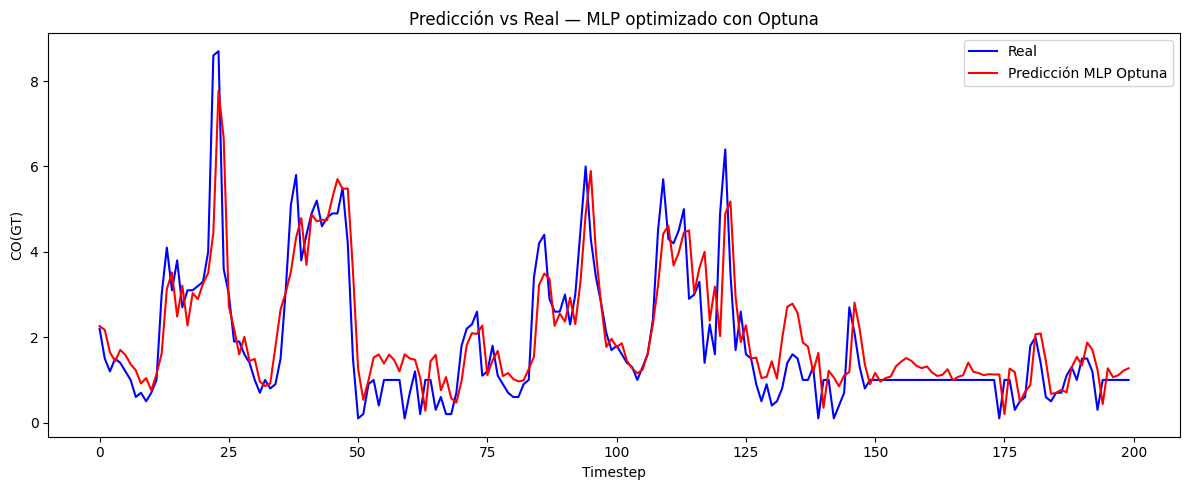

In [68]:
#modelo con los mejores hipermarámetros
params = study.best_params
n_layers = params['n_layers']
units = [params[f'n_units_l{i}'] for i in range(n_layers)]
activation = params['activation']
lr = params['lr']
batch_size = params['batch_size']

# Modelo óptimo
best_model = Sequential()
best_model.add(Dense(units[0], activation=activation, input_shape=(window_size,)))
for u in units[1:]:
    best_model.add(Dense(u, activation=activation))
best_model.add(Dense(1))
best_model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

# Entrenar de nuevo con mejores hiperparámetros
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)

# Predecir
y_pred = best_model.predict(X_test)

# Invertir escala
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Gráfica de comparación
import matplotlib.pyplot as plt

n = 200  # mostrar primeros 200 puntos
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:n], label='Real', color='blue')
plt.plot(y_pred_inv[:n], label='Predicción MLP Optuna', color='red')
plt.title('Predicción vs Real — MLP optimizado con Optuna')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


La predicción de este modelo MLP con los mejores hiperparámetros de optuna parece ajustarse muy bien a los datos reales. Sigue de muy buena manera los datos. Obtuvo un r2 de 82.